In [1]:
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Root_Insurance_data.csv",delimiter = ",")
data_click_proba = pd.read_csv("data_click_probability.csv",delimiter = ",")

In [3]:
## Input: Data Frame (in the format of "Root_Insurance_data.csv") and encode_rank (default = False)
## Output: Data Frame (processed by one hot encoding ready to be used to make models)

## This function will one hot encode the following columns in the data frame: 
## Currently Insured, Marital Status, click, rank (optional, determined by encode_rank = True)
## and will drop the respective columns associated to the respective values of above columns:
## unknown, S, False, 5.0 (if encode_rank = True)

import category_encoders as ce

def prepare_data(data:pd.DataFrame(), encode_rank = False, click_proba = False) -> pd.DataFrame():
    temp = data.copy()
    
    if not click_proba:
        if encode_rank:
            one_hot_cols = ["Currently Insured", "Marital Status", "click", "rank"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0", "click_False"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                            'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                            'rank_2.0', 'rank_3.0', 'rank_4.0', 'click_True', 'policies_sold']
        else:
            one_hot_cols = ["Currently Insured", "Marital Status", "click"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "click_False"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                            'Marital Status_M', 'bid', 'rank', 'click_True', 'policies_sold']
    else:
        if encode_rank:
            one_hot_cols = ["Currently Insured", "Marital Status", "rank"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                            'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                            'rank_2.0', 'rank_3.0', 'rank_4.0', 'click', 'policies_sold']
        else:
            one_hot_cols = ["Currently Insured", "Marital Status"]
            drop_cols = ["Currently Insured_unknown", "Marital Status_S"]
            column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                            'Marital Status_M', 'bid', 'rank', 'click', 'policies_sold']
    
    encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
    temp = encoder.fit_transform(temp)
    temp = temp.drop(columns = drop_cols)
    temp = temp.reindex(columns=column_names)
    return temp

In [4]:
#df = prepare_data(data, click_proba = False)


df = prepare_data(data_click_proba, click_proba = True)

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [5]:
list(df.columns)[:-1]

['Currently Insured_Y',
 'Currently Insured_N',
 'Number of Vehicles',
 'Number of Drivers',
 'Marital Status_M',
 'bid',
 'rank',
 'click']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score

features = list(df.columns)[:-1]
predictor_var = "policies_sold"

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     random_state=12345,
                                     test_size=.2,
                                     stratify=df[predictor_var])

In [7]:
def resample_data(df:pd.DataFrame(), resample_type = "None") -> pd.DataFrame():
    df_minority = df[df[predictor_var] == 1]
    df_majority = df[df[predictor_var] != 1]
    if resample_type == "Up":
        df_minority_up = resample(df_minority,
                                  random_state=886,
                                  n_samples=len(df_majority),
                                  replace=True)
        df_resampled = pd.concat([df_minority_up, df_majority]).sample(frac=1, random_state = 0)
    elif resample_type == "Down":
        df_majority_down = resample(df_majority,
                                    random_state=886,
                                    n_samples=len(df_minority),
                                    replace=True)
        df_resampled = pd.concat([df_majority_down, df_minority]).sample(frac=1, random_state = 0)
    elif resample_type == "Balanced":
        df_majority_bal = resample(df_majority,
                                           random_state=886,
                                           n_samples= int(len(df)/2),
                                           replace=True)
        df_minority_bal = resample(df_minority,
                                               random_state=886,
                                               n_samples=int(len(df)/2),
                                               replace=True)
        df_resampled = pd.concat([df_majority_bal, df_minority_bal]).sample(frac=1, random_state = 0) 
    else:
        df_resampled = df
    return df_resampled

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample,shuffle


avg_precision_cross_val = 0
roc_auc_cross_val = 0
accuracy_cross_val = 0


df_train_resampled = resample_data(df_train, resample_type = "None")

log_reg = LogisticRegression(C=1)
log_reg.fit(df_train[features], 
            np.array(df_train[predictor_var]).ravel())

y_proba = log_reg.predict_proba(df_test[features])[:,1]
y_pred = log_reg.predict(df_test[features])

avg_precision_cross_val = average_precision_score(df_test[predictor_var], y_proba)
roc_auc_cross_val = roc_auc_score(df_test[predictor_var], y_proba)
accuracy_cross_val = accuracy_score(df_test[predictor_var], y_pred)

In [9]:
print(avg_precision_cross_val)
print(roc_auc_cross_val)
print(accuracy_cross_val)

0.1963909011015563
0.7673016509360604
0.9215


In [10]:
y_pred = [int(x > .2) for x in y_proba]
accuracy_score(df_test[predictor_var], y_pred)

0.843

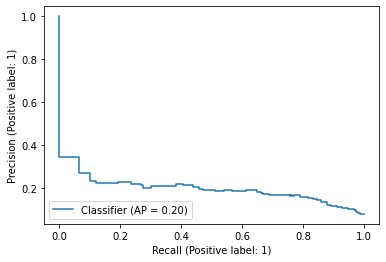

In [11]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(df_test[predictor_var],log_reg.predict_proba(df_test[features])[:,1])

In [12]:
precision, recall, pr_threshold = precision_recall_curve(df_test[predictor_var], log_reg.predict_proba(df_test[features])[:,1])

In [13]:
thres_pr_elbow = np.argmin([int(x > .4) for x in recall])

In [14]:
print(precision[thres_pr_elbow])
print(recall[thres_pr_elbow])
print(pr_threshold[thres_pr_elbow])

0.2127659574468085
0.3821656050955414
0.17011010674553836


In [15]:
data_clicks_proba = data_click_proba.copy()

In [16]:
log_reg = LogisticRegression(C=1)
log_reg.fit(df[features], 
            np.array(df[predictor_var]).ravel())

LogisticRegression(C=1)

In [17]:
data_clicks_proba["policies_sold"] = log_reg.predict_proba(df[features])[:,1]

In [18]:
data_clicks_proba.to_csv('data_policies_sold_probability.csv', index=False)

In [19]:
unique_data_clicks_proba = data_clicks_proba.drop_duplicates(subset = ["Currently Insured",
                                                                       "Number of Vehicles",
                                                                       "Number of Drivers",
                                                                       "Marital Status", 
                                                                       "rank"])

In [20]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
unique_data_clicks_proba.sort_values(by=['policies_sold'], ascending = False)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
156,unknown,1,1,S,10,1,0.531215,0.286567
113,unknown,1,1,M,10,1,0.531215,0.267917
40,unknown,1,2,S,10,1,0.531215,0.247327
44,unknown,2,1,S,10,1,0.516352,0.240693
347,N,1,2,S,10,1,0.513325,0.234233
9,unknown,1,2,M,10,1,0.531215,0.230407
102,unknown,2,1,M,10,1,0.516352,0.224091
142,N,1,2,M,10,1,0.513325,0.217949
183,Y,1,1,S,10,1,0.544504,0.215141
34,unknown,2,2,S,10,1,0.516352,0.205922


In [22]:
print(log_reg.coef_)

[[-0.37329617 -0.08348676 -0.24660804 -0.20080112 -0.09309789  0.06893351
  -0.81054899 -0.6620676 ]]


In [28]:
all_data = pd.read_pickle("click_proba_df.pkl")

In [35]:
import category_encoders as ce

one_hot_cols = ["Currently Insured", "Marital Status"]
drop_cols = ["Currently Insured_unknown", "Marital Status_S"]
column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                'Marital Status_M', 'bid', 'click', 'rank']
encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
temp = encoder.fit_transform(all_data)
temp = temp.drop(columns = drop_cols)
all_data_prep = temp.reindex(columns=column_names)

all_data["policies_sold"] = log_reg.predict_proba(all_data_prep[features])[:,1]

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [36]:
all_data

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,1,1,M,10,1,0.531215,0.267917
1,unknown,1,1,M,10,2,0.316863,0.157912
2,unknown,1,1,M,10,3,0.159565,0.084691
3,unknown,1,1,M,10,4,0.072110,0.041770
4,unknown,1,1,M,10,5,0.030830,0.019529
5,unknown,1,1,S,10,1,0.531215,0.286567
6,unknown,1,1,S,10,2,0.316863,0.170689
7,unknown,1,1,S,10,3,0.159565,0.092192
8,unknown,1,1,S,10,4,0.072110,0.045660
9,unknown,1,1,S,10,5,0.030830,0.021394


In [37]:
all_data.to_pickle("click_policies_proba.pkl")